This script solves the homogeneous spring equation:
$$m \frac{d^2 z}{dt^2} + c \frac{dz}{dt} + kz = 0, \ \ \ z(0) = z_0, \ \ \  \frac{dz}{dt}(0) = v_0 $$
where $m$ is the mass (kg), $c$ represents the damper (kg / s), and $k$ represents the spring stiffness (kg/$s^2$). 

The second order system is recast as two-dimensional, first order system

$$\frac{d\mathbf{u}}{dt} = \mathbf{A}\mathbf{u}, \ \ \mathbf{u} = \begin{bmatrix} z \\ \frac{dz}{dt} \end{bmatrix}, \ \  \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -K & -C \end{bmatrix}$$

where $\mathbf{u}_0 = [z_0,v_0]^\top$ are the initial conditions. The new parameters $K=k/m$ and $C=c/m$ reduce identifiability issues.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

In [3]:
# Spring model function
def spring_model_2par(y, t, params):
    C, K = params
    x, v = y

    # RHS equations
    dxdt = v
    dvdt = (-C * v - K * x)
    return [dxdt, dvdt]


# Call the spring model
def call_spring_model(q, IC, tspace):
    params = q[:2]
    solution = odeint(spring_model_2par, IC, tspace, args=(params,))
    return solution[:, 0]  # Only displacement data

# Ordinary Least Squares cost function
def get_spring_cost(q, tspace, data, IC):
    sim = call_spring_model(q, IC, tspace)
    residual = data - sim
    return np.sum(residual**2)

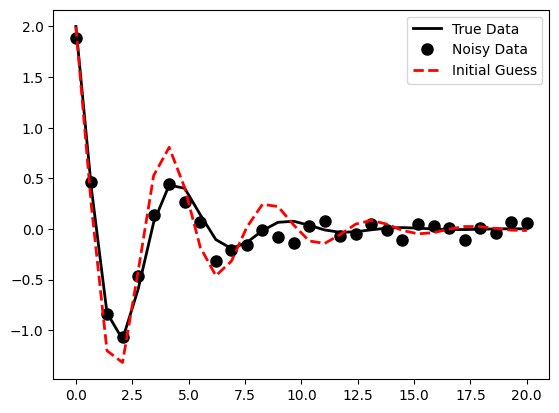

In [4]:
# Initial conditions
x0 = 2
v0 = -2
IC = [x0, v0]

# Parameters
param_star = [0.7, 1.7]
param_guess = [0.5,2.0]
tend = 20
tspace = np.linspace(0, tend, 30)

# Generate true data and noisy data
true_data = call_spring_model(param_star, IC, tspace)
noisy_data = true_data + np.random.normal(0, 0.1, len(tspace))
initial_guess = call_spring_model(param_guess, IC, tspace)

# Plot initial fits
plt.figure(1)
plt.plot(tspace, true_data, '-k', linewidth=2, label="True Data")
plt.plot(tspace, noisy_data, 'ko', markersize=8, label="Noisy Data")
plt.plot(tspace, initial_guess, '--r', linewidth=2, label="Initial Guess")
plt.legend()
plt.show()

Final estimate
[0.74700809 1.85250566]
True value
[0.7, 1.7]


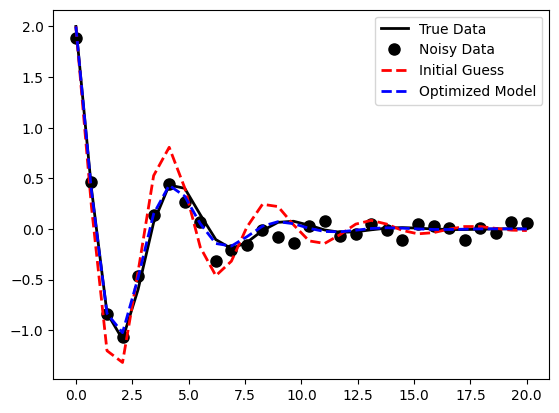

Parameter CI
[[0.68062663 0.81338955]
 [1.73260823 1.97240308]]


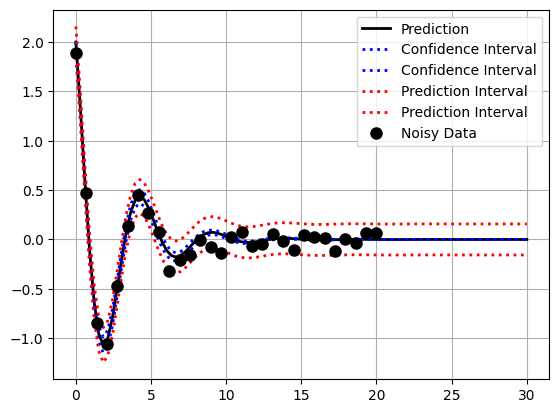

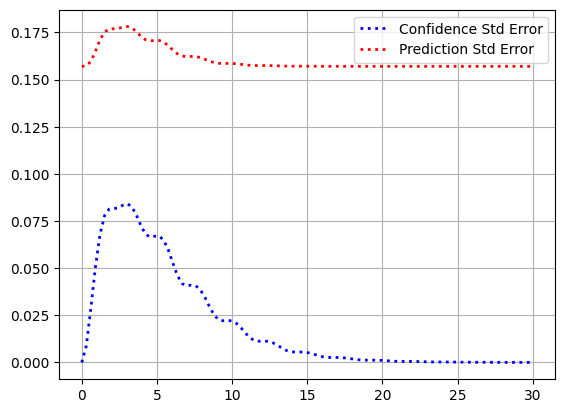

In [6]:
# Optimize parameters
result = minimize(get_spring_cost, param_guess, args=(tspace, noisy_data, IC))
param_opt = result.x

print("Final estimate")
print(param_opt)
print("True value")
print(param_star)

# Plot optimized model
plt.figure(1)
plt.plot(tspace, true_data, '-k', linewidth=2, label="True Data")
plt.plot(tspace, noisy_data, 'ko', markersize=8, label="Noisy Data")
plt.plot(tspace, initial_guess, '--r', linewidth=2, label="Initial Guess")
plt.plot(tspace, call_spring_model(param_opt, IC, tspace), '--b', linewidth=2, label="Optimized Model")
plt.legend()
plt.show()

# Confidence intervals using finite differences
num_param = 2
n_xpts = len(tspace)
S = np.zeros((n_xpts, num_param))
h = 1e-8

for i in range(num_param):
    param_step = param_opt.copy()
    param_step[i] += h
    S[:, i] = (call_spring_model(param_step, IC, tspace) - call_spring_model(param_opt, IC, tspace)) / h

res = noisy_data - call_spring_model(param_opt, IC, tspace)
s2 = np.dot(res, res) / (n_xpts - num_param)
covar = s2 * np.linalg.inv(S.T @ S)

CI_plus = param_opt + 1.96 * np.sqrt(np.diag(covar))
CI_minus = param_opt - 1.96 * np.sqrt(np.diag(covar))

print("Parameter CI")
print(np.column_stack((CI_minus, CI_plus)))

# Prediction intervals
t_test = np.linspace(0, 1.5 * max(tspace), 100)
n_xtest = len(t_test)
g = np.zeros((n_xtest, num_param))

for i in range(num_param):
    param_step = param_opt.copy()
    param_step[i] += h
    g[:, i] = (call_spring_model(param_step, IC, t_test) - call_spring_model(param_opt, IC, t_test)) / h

Y_pred = call_spring_model(param_opt, IC, t_test)
Y_CI = np.zeros((n_xtest, 2))
Y_PI = np.zeros((n_xtest, 2))
y_stderr_CI = np.zeros(n_xtest)
y_stderr_PI = np.zeros(n_xtest)

for i in range(n_xtest):
    y_stderr_CI[i] = 1.96 * np.sqrt(g[i, :] @ covar @ g[i, :])
    Y_CI[i, 0] = Y_pred[i] + y_stderr_CI[i]
    Y_CI[i, 1] = Y_pred[i] - y_stderr_CI[i]

    y_stderr_PI[i] = 1.96 * np.sqrt(s2 + g[i, :] @ covar @ g[i, :])
    Y_PI[i, 0] = Y_pred[i] + y_stderr_PI[i]
    Y_PI[i, 1] = Y_pred[i] - y_stderr_PI[i]

# Plot response, CI, and PI
plt.figure(2)
plt.plot(t_test, Y_pred, '-k', linewidth=2, label="Prediction")
plt.plot(t_test, Y_CI, ':b', linewidth=2, label="Confidence Interval")
plt.plot(t_test, Y_PI, ':r', linewidth=2, label="Prediction Interval")
plt.plot(tspace, noisy_data, 'ko', markersize=8, label="Noisy Data")
plt.legend()
plt.grid()
plt.show()

# Plot standard errors
plt.figure(3)
plt.plot(t_test, y_stderr_CI, ':b', linewidth=2, label="Confidence Std Error")
plt.plot(t_test, y_stderr_PI, ':r', linewidth=2, label="Prediction Std Error")
plt.legend()
plt.grid()
plt.show()